In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt


In [2]:
# Initialize the CartPole-v1 environment
env = gym.make('CartPole-v1')

# Extract state and action dimensions
state_dim = env.observation_space.shape[0]  # 4 for CartPole
action_dim = env.action_space.n  # 2 for CartPole (discrete actions)

# Set the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
class ReplayBuffer:
    def __init__(self, max_size=1e6):
        self.buffer = deque(maxlen=int(max_size))

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.tensor(states, dtype=torch.float32).to(device),
                torch.tensor(actions, dtype=torch.float32).to(device),
                torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device),
                torch.tensor(next_states, dtype=torch.float32).to(device),
                torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device))


In [4]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, action_dim)

    def forward(self, state):
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        action_probs = torch.softmax(self.layer3(x), dim=-1)
        return action_probs


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(state_dim + 1, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 1)

    def forward(self, state, action):
        action = action.unsqueeze(1) if len(action.shape) == 1 else action
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        q_value = self.layer3(x)
        return q_value


In [5]:
class DDPGAgent:
    def __init__(self, state_dim, action_dim):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_target = Actor(state_dim, action_dim).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.replay_buffer = ReplayBuffer()
        self.gamma = 0.99
        self.tau = 0.01

    def select_action(self, state, noise_scale=0.1):
        # Ensure the state is a NumPy array
        if isinstance(state, (list, tuple)):
            state = np.array(state, dtype=np.float32)  # Convert to NumPy array
        elif not isinstance(state, np.ndarray):
            raise ValueError(f"Unexpected state type: {type(state)}")

        state = state.reshape(1, -1)  # Reshape to (1, state_dim)
        state = torch.tensor(state, dtype=torch.float32).to(device)

        # Get action probabilities from the actor
        action_probs = self.actor(state).detach().cpu().numpy()[0]

        # Add exploration noise
        noise = noise_scale * np.random.randn(len(action_probs))
        action = np.argmax(action_probs + noise)
        return action

    def train(self, batch_size=64):
        if len(self.replay_buffer.buffer) < 1000:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        # Critic loss
        with torch.no_grad():
            next_action_probs = self.actor_target(next_states)
            next_actions = torch.argmax(next_action_probs, dim=1).float().unsqueeze(1)
            target_q = rewards + self.gamma * (1 - dones) * self.critic_target(next_states, next_actions)

        current_q = self.critic(states, actions.float().unsqueeze(1))
        critic_loss = nn.MSELoss()(current_q, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        predicted_actions = self.actor(states).argmax(dim=1).float().unsqueeze(1)
        actor_loss = -self.critic(states, predicted_actions).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


In [30]:
# Actor Network for SAC with Discrete Actions
class ActorSACDiscrete(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorSACDiscrete, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, action_dim)  # Output one logit per discrete action

    def forward(self, state):
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        logits = self.layer3(x)  # Output logits
        action_probs = torch.softmax(logits, dim=-1)  # Convert to probabilities
        return action_probs
    
# Critic Network for SAC with Discrete Actions
class CriticSACDiscrete(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticSACDiscrete, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, action_dim)  # Output Q-value for each action

    def forward(self, state):
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        q_values = self.layer3(x)  # Q-values for each action
        return q_values


In [31]:
class SACAgentDiscrete:
    def __init__(self, state_dim, action_dim, alpha=0.2):
        self.actor = ActorSACDiscrete(state_dim, action_dim).to(device)
        self.critic1 = CriticSACDiscrete(state_dim, action_dim).to(device)
        self.critic2 = CriticSACDiscrete(state_dim, action_dim).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=1e-3)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=1e-3)

        self.replay_buffer = ReplayBuffer()
        self.gamma = 0.99
        self.tau = 0.005
        self.alpha = alpha  # Fixed entropy coefficient for simplicity

    def select_action(self, state):
        state = np.array(state, dtype=np.float32).reshape(1, -1)
        state = torch.tensor(state, dtype=torch.float32).to(device)
        action_probs = self.actor(state).detach().cpu().numpy()[0]
        action = np.random.choice(len(action_probs), p=action_probs)  # Sample an action
        return action

    def train(self, batch_size=64):
        if len(self.replay_buffer.buffer) < 1000:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        # Critic loss
        with torch.no_grad():
            next_action_probs = self.actor(next_states)
            next_q1 = self.critic1(next_states)
            next_q2 = self.critic2(next_states)
            target_q = rewards + self.gamma * (1 - dones) * (
                (next_action_probs * torch.min(next_q1, next_q2)).sum(dim=1, keepdim=True)
                - self.alpha * torch.sum(next_action_probs * torch.log(next_action_probs + 1e-6), dim=1, keepdim=True)
            )

        current_q1 = self.critic1(states).gather(1, actions.long().unsqueeze(1))
        current_q2 = self.critic2(states).gather(1, actions.long().unsqueeze(1))
        critic1_loss = nn.MSELoss()(current_q1, target_q)
        critic2_loss = nn.MSELoss()(current_q2, target_q)

        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        # Actor loss
        action_probs = self.actor(states)
        log_probs = torch.log(action_probs + 1e-6)
        q_values = torch.min(self.critic1(states), self.critic2(states))
        actor_loss = torch.sum(action_probs * (self.alpha * log_probs - q_values), dim=1).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()



In [32]:
# Initialize SAC Agent
sac_agent = SACAgentDiscrete(state_dim, action_dim)

# Train SAC
episodes = 5000
training_rewards_sac = []
batch_size = 64
warmup_steps = 1000

for episode in range(episodes):
    state, _ = env.reset(seed=42)  # Unpack the state
    episode_reward = 0
    done = False

    while not done:
        action = sac_agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        sac_agent.replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state
        episode_reward += reward

        if len(sac_agent.replay_buffer.buffer) >= warmup_steps:
            sac_agent.train(batch_size=batch_size)

    training_rewards_sac.append(episode_reward)
    print(f"SAC - Episode {episode + 1}: Reward = {episode_reward}")


SAC - Episode 1: Reward = 16.0
SAC - Episode 2: Reward = 14.0
SAC - Episode 3: Reward = 16.0
SAC - Episode 4: Reward = 24.0
SAC - Episode 5: Reward = 25.0
SAC - Episode 6: Reward = 19.0
SAC - Episode 7: Reward = 20.0
SAC - Episode 8: Reward = 19.0
SAC - Episode 9: Reward = 24.0
SAC - Episode 10: Reward = 16.0
SAC - Episode 11: Reward = 10.0
SAC - Episode 12: Reward = 13.0
SAC - Episode 13: Reward = 28.0
SAC - Episode 14: Reward = 18.0
SAC - Episode 15: Reward = 17.0
SAC - Episode 16: Reward = 9.0
SAC - Episode 17: Reward = 15.0
SAC - Episode 18: Reward = 30.0
SAC - Episode 19: Reward = 29.0
SAC - Episode 20: Reward = 29.0
SAC - Episode 21: Reward = 33.0
SAC - Episode 22: Reward = 20.0
SAC - Episode 23: Reward = 16.0
SAC - Episode 24: Reward = 12.0
SAC - Episode 25: Reward = 41.0
SAC - Episode 26: Reward = 38.0
SAC - Episode 27: Reward = 26.0
SAC - Episode 28: Reward = 16.0
SAC - Episode 29: Reward = 20.0
SAC - Episode 30: Reward = 25.0
SAC - Episode 31: Reward = 41.0
SAC - Episode 32: 

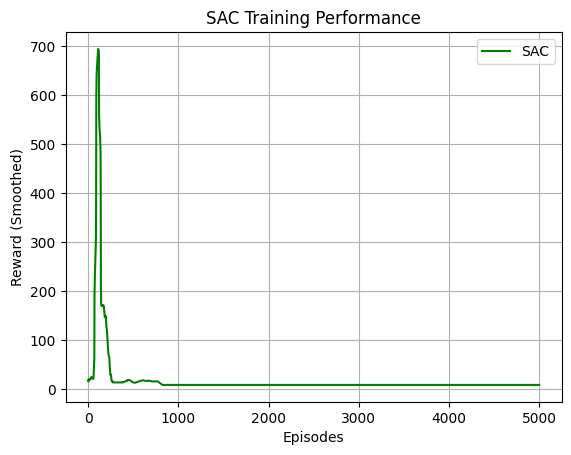

In [ ]:

window = 50
sac_avg = [np.mean(training_rewards_sac[max(0, i - window):(i + 1)]) for i in range(len(training_rewards_sac))]
plt.plot(sac_avg, label='SAC', color='green')
plt.title('SAC Training Performance')
plt.xlabel('Episodes')
plt.ylabel('Reward (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
def evaluate_sac_agent(env, sac_agent, num_episodes=10):
    """
    Evaluate the SAC agent on the environment.

    Args:
    - env: The environment (e.g., CartPole).
    - sac_agent: The trained SAC agent.
    - num_episodes: Number of episodes to evaluate the agent.

    Returns:
    - avg_reward: Average reward over the evaluation episodes.
    """
    total_rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()  # Reset the environment
        done = False
        episode_reward = 0

        while not done:
            # Select the action deterministically
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
            action_probs = sac_agent.actor(state_tensor)
            action = torch.argmax(action_probs, dim=1).item()  # Choose the action with the highest probability

            # Step in the environment
            state, reward, done, _, _ = env.step(action)
            episode_reward += reward

        total_rewards.append(episode_reward)
        print(f"Evaluation Episode {episode + 1}: Reward = {episode_reward}")

    avg_reward = np.mean(total_rewards)
    print(f"\nAverage Reward over {num_episodes} Evaluation Episodes: {avg_reward}")
    return avg_reward
avg_reward = evaluate_sac_agent(env, sac_agent, num_episodes=10)

Evaluation Episode 1: Reward = 9.0
Evaluation Episode 2: Reward = 10.0
Evaluation Episode 3: Reward = 10.0
Evaluation Episode 4: Reward = 9.0
Evaluation Episode 5: Reward = 8.0
Evaluation Episode 6: Reward = 10.0
Evaluation Episode 7: Reward = 9.0
Evaluation Episode 8: Reward = 10.0
Evaluation Episode 9: Reward = 10.0
Evaluation Episode 10: Reward = 9.0

Average Reward over 10 Evaluation Episodes: 9.4


In [7]:
class TD3Agent:
    def __init__(self, state_dim, action_dim):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_target = Actor(state_dim, action_dim).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic1 = Critic(state_dim, action_dim).to(device)
        self.critic2 = Critic(state_dim, action_dim).to(device)
        self.critic1_target = Critic(state_dim, action_dim).to(device)
        self.critic2_target = Critic(state_dim, action_dim).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=1e-3)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=1e-3)

        self.replay_buffer = ReplayBuffer()
        self.gamma = 0.99
        self.tau = 0.01
        self.policy_delay = 2  # Update policy every `policy_delay` steps
        self.noise_std = 0.2
        self.noise_clip = 0.5
        self.policy_update_counter = 0

    def select_action(self, state, noise_scale=0.1):
        # Ensure the state is a NumPy array
        if isinstance(state, (list, tuple)):
            state = np.array(state, dtype=np.float32)  # Convert to NumPy array
        elif not isinstance(state, np.ndarray):
            raise ValueError(f"Unexpected state type: {type(state)}")

        state = state.reshape(1, -1)  # Reshape to (1, state_dim)
        state = torch.tensor(state, dtype=torch.float32).to(device)

        # Get action probabilities from the actor
        action_probs = self.actor(state).detach().cpu().numpy()[0]

        # Add exploration noise
        noise = noise_scale * np.random.randn(len(action_probs))
        action = np.argmax(action_probs + noise)
        return action

    def train(self, batch_size=64):
        if len(self.replay_buffer.buffer) < 1000:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        # Critic loss
        with torch.no_grad():
            next_action_probs = self.actor_target(next_states)
            noise = torch.clamp(torch.randn_like(next_action_probs) * self.noise_std, -self.noise_clip, self.noise_clip)
            next_actions = torch.argmax(next_action_probs + noise, dim=1).float().unsqueeze(1)
            target_q1 = self.critic1_target(next_states, next_actions)
            target_q2 = self.critic2_target(next_states, next_actions)
            target_q = rewards + self.gamma * (1 - dones) * torch.min(target_q1, target_q2)

        current_q1 = self.critic1(states, actions.float().unsqueeze(1))
        current_q2 = self.critic2(states, actions.float().unsqueeze(1))
        critic1_loss = nn.MSELoss()(current_q1, target_q)
        critic2_loss = nn.MSELoss()(current_q2, target_q)

        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        # Delayed actor update
        if self.policy_update_counter % self.policy_delay == 0:
            predicted_actions = self.actor(states)
            actor_loss = -self.critic1(states, predicted_actions.argmax(dim=1).float().unsqueeze(1)).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update target networks
            for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for target_param, param in zip(self.critic1_target.parameters(), self.critic1.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for target_param, param in zip(self.critic2_target.parameters(), self.critic2.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        self.policy_update_counter += 1


In [ ]:
class D4PGAgent:
    def __init__(self, state_dim, action_dim, num_atoms=51, v_min=-10, v_max=10):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_target = Actor(state_dim, action_dim).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.replay_buffer = ReplayBuffer()
        self.gamma = 0.99
        self.tau = 0.005

        # Distributional Critic
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.delta_z = (v_max - v_min) / (num_atoms - 1)
        self.z_atoms = torch.linspace(v_min, v_max, num_atoms).to(device)

    def select_action(self, state, noise_scale=0.1):
        # Ensure the state is a NumPy array
        if isinstance(state, (list, tuple)):
            state = np.array(state, dtype=np.float32)  # Convert to NumPy array
        elif not isinstance(state, np.ndarray):
            raise ValueError(f"Unexpected state type: {type(state)}")

        state = state.reshape(1, -1)  # Reshape to (1, state_dim)
        state = torch.tensor(state, dtype=torch.float32).to(device)

        # Get action probabilities from the actor
        action_probs = self.actor(state).detach().cpu().numpy()[0]

        # Add exploration noise
        noise = noise_scale * np.random.randn(len(action_probs))
        action = np.argmax(action_probs + noise)
        return action

    def train(self, batch_size=64):
        if len(self.replay_buffer.buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        # Compute target distribution
        with torch.no_grad():
            next_action_probs = self.actor(next_states)
            next_actions = torch.argmax(next_action_probs, dim=1, keepdim=True)
            next_z_dist = self.critic_target(next_states, next_actions).softmax(dim=-1)

            next_support = rewards.unsqueeze(1) + self.gamma * (1 - dones.unsqueeze(1)) * self.z
            next_support = next_support.clamp(min=self.z_min, max=self.z_max)

            target_dist = torch.zeros_like(next_z_dist)  # Shape: [batch_size, num_atoms]

            for i in range(self.num_atoms):
                l = torch.floor((next_support - self.z[i]) / self.delta_z).long().clamp(0, self.num_atoms - 1)
                u = torch.ceil((next_support - self.z[i]) / self.delta_z).long().clamp(0, self.num_atoms - 1)

                # Update target distribution using per-batch alignment
                target_dist.scatter_add_(1, l, next_z_dist[:, i] * (u.float() - (next_support - self.z[i]) / self.delta_z))
                target_dist.scatter_add_(1, u, next_z_dist[:, i] * ((next_support - self.z[i]) / self.delta_z - l.float()))

        # Critic loss
        z_dist = self.critic(states, actions.unsqueeze(1))
        critic_loss = -(target_dist * torch.log(z_dist + 1e-6)).sum(dim=-1).mean()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        action_probs = self.actor(states)
        sampled_actions = torch.multinomial(action_probs, 1).float()
        actor_loss = -self.critic(states, sampled_actions).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update for target network
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)



In [9]:
# Training setup
episodes = 5000  # Number of episodes to train
batch_size = 64  # Batch size for training
warmup_steps = 1000  # Minimum steps before training
max_steps_per_episode = 500  # Maximum steps per episode

# Collect rewards for comparison
training_rewards_ddpg = []
training_rewards_sac = []
training_rewards_td3 = []
training_rewards_d4pg = []

# Noise scaling for exploration
def get_noise_scale(episode, max_episodes):
    return max(0.1, 1.0 - episode / max_episodes)


In [10]:
ddpg_agent = DDPGAgent(state_dim, action_dim)

for episode in range(episodes):
    state, _ = env.reset(seed=42)  # Extract state from tuple
    noise_scale = max(0.1, 1.0 - episode / episodes)
    episode_reward = 0
    done = False
    step_count = 0

    while not done and step_count < max_steps_per_episode:
        action = ddpg_agent.select_action(state, noise_scale=noise_scale)
        next_state, reward, done, _, _ = env.step(action)  # Extract state from tuple
        ddpg_agent.replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state
        episode_reward += reward
        step_count += 1

        if len(ddpg_agent.replay_buffer.buffer) >= warmup_steps:
            ddpg_agent.train(batch_size=batch_size)

    training_rewards_ddpg.append(episode_reward)
    print(f"DDPG - Episode {episode + 1}: Reward = {episode_reward}")

    if len(training_rewards_ddpg) > 50 and np.mean(training_rewards_ddpg[-50:]) >= 200:
        print(f"DDPG solved after {episode + 1} episodes!")
        break


DDPG - Episode 1: Reward = 38.0
DDPG - Episode 2: Reward = 16.0
DDPG - Episode 3: Reward = 16.0
DDPG - Episode 4: Reward = 11.0
DDPG - Episode 5: Reward = 16.0
DDPG - Episode 6: Reward = 33.0
DDPG - Episode 7: Reward = 13.0
DDPG - Episode 8: Reward = 9.0
DDPG - Episode 9: Reward = 45.0
DDPG - Episode 10: Reward = 19.0
DDPG - Episode 11: Reward = 21.0
DDPG - Episode 12: Reward = 29.0
DDPG - Episode 13: Reward = 16.0
DDPG - Episode 14: Reward = 22.0
DDPG - Episode 15: Reward = 40.0
DDPG - Episode 16: Reward = 15.0
DDPG - Episode 17: Reward = 11.0
DDPG - Episode 18: Reward = 31.0
DDPG - Episode 19: Reward = 79.0
DDPG - Episode 20: Reward = 11.0
DDPG - Episode 21: Reward = 23.0
DDPG - Episode 22: Reward = 44.0
DDPG - Episode 23: Reward = 14.0
DDPG - Episode 24: Reward = 51.0
DDPG - Episode 25: Reward = 26.0
DDPG - Episode 26: Reward = 24.0
DDPG - Episode 27: Reward = 38.0
DDPG - Episode 28: Reward = 15.0
DDPG - Episode 29: Reward = 46.0
DDPG - Episode 30: Reward = 12.0
DDPG - Episode 31: R

/tmp/ipykernel_1508511/1246399925.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return (torch.tensor(states, dtype=torch.float32).to(device),


DDPG - Episode 42: Reward = 39.0
DDPG - Episode 43: Reward = 17.0
DDPG - Episode 44: Reward = 21.0
DDPG - Episode 45: Reward = 29.0
DDPG - Episode 46: Reward = 20.0
DDPG - Episode 47: Reward = 35.0
DDPG - Episode 48: Reward = 26.0
DDPG - Episode 49: Reward = 20.0
DDPG - Episode 50: Reward = 26.0
DDPG - Episode 51: Reward = 22.0
DDPG - Episode 52: Reward = 13.0
DDPG - Episode 53: Reward = 16.0
DDPG - Episode 54: Reward = 24.0
DDPG - Episode 55: Reward = 23.0
DDPG - Episode 56: Reward = 28.0
DDPG - Episode 57: Reward = 13.0
DDPG - Episode 58: Reward = 32.0
DDPG - Episode 59: Reward = 26.0
DDPG - Episode 60: Reward = 9.0
DDPG - Episode 61: Reward = 26.0
DDPG - Episode 62: Reward = 25.0
DDPG - Episode 63: Reward = 42.0
DDPG - Episode 64: Reward = 28.0
DDPG - Episode 65: Reward = 26.0
DDPG - Episode 66: Reward = 18.0
DDPG - Episode 67: Reward = 32.0
DDPG - Episode 68: Reward = 16.0
DDPG - Episode 69: Reward = 18.0
DDPG - Episode 70: Reward = 18.0
DDPG - Episode 71: Reward = 14.0
DDPG - Epis

In [11]:
# Initialize SAC Agent
sac_agent = SACAgent(state_dim, action_dim)

# Train SAC
training_rewards_sac = []

for episode in range(episodes):
    state, _ = env.reset(seed=42)  # Unpack the state
    episode_reward = 0
    done = False

    while not done:
        action = sac_agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        sac_agent.replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state
        episode_reward += reward

        if len(sac_agent.replay_buffer.buffer) >= warmup_steps:
            sac_agent.train(batch_size=batch_size)

    training_rewards_sac.append(episode_reward)
    print(f"SAC - Episode {episode + 1}: Reward = {episode_reward}")


SAC - Episode 1: Reward = 11.0
SAC - Episode 2: Reward = 12.0
SAC - Episode 3: Reward = 22.0
SAC - Episode 4: Reward = 15.0
SAC - Episode 5: Reward = 19.0
SAC - Episode 6: Reward = 20.0
SAC - Episode 7: Reward = 14.0
SAC - Episode 8: Reward = 13.0
SAC - Episode 9: Reward = 10.0
SAC - Episode 10: Reward = 18.0
SAC - Episode 11: Reward = 12.0
SAC - Episode 12: Reward = 15.0
SAC - Episode 13: Reward = 15.0
SAC - Episode 14: Reward = 10.0
SAC - Episode 15: Reward = 10.0
SAC - Episode 16: Reward = 12.0
SAC - Episode 17: Reward = 10.0
SAC - Episode 18: Reward = 10.0
SAC - Episode 19: Reward = 13.0
SAC - Episode 20: Reward = 15.0
SAC - Episode 21: Reward = 10.0
SAC - Episode 22: Reward = 12.0
SAC - Episode 23: Reward = 14.0
SAC - Episode 24: Reward = 10.0
SAC - Episode 25: Reward = 10.0
SAC - Episode 26: Reward = 12.0
SAC - Episode 27: Reward = 12.0
SAC - Episode 28: Reward = 10.0
SAC - Episode 29: Reward = 11.0
SAC - Episode 30: Reward = 17.0
SAC - Episode 31: Reward = 11.0
SAC - Episode 32:

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [36]:
# Initialize TD3 Agent
td3_agent = TD3Agent(state_dim, action_dim)

# Train TD3
training_rewards_td3 = []

for episode in range(episodes):
    state, _ = env.reset(seed=42)  # Unpack the state
    noise_scale = max(0.1, 1.0 - episode / episodes)
    episode_reward = 0
    done = False

    while not done:
        action = td3_agent.select_action(state, noise_scale=noise_scale)
        next_state, reward, done, _, _ = env.step(action)
        td3_agent.replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state
        episode_reward += reward

        if len(td3_agent.replay_buffer.buffer) >= warmup_steps:
            td3_agent.train(batch_size=batch_size)

    training_rewards_td3.append(episode_reward)
    print(f"TD3 - Episode {episode + 1}: Reward = {episode_reward}")


TD3 - Episode 1: Reward = 18.0
TD3 - Episode 2: Reward = 11.0
TD3 - Episode 3: Reward = 44.0
TD3 - Episode 4: Reward = 19.0
TD3 - Episode 5: Reward = 23.0
TD3 - Episode 6: Reward = 22.0
TD3 - Episode 7: Reward = 13.0
TD3 - Episode 8: Reward = 26.0
TD3 - Episode 9: Reward = 14.0
TD3 - Episode 10: Reward = 15.0
TD3 - Episode 11: Reward = 27.0
TD3 - Episode 12: Reward = 17.0
TD3 - Episode 13: Reward = 29.0
TD3 - Episode 14: Reward = 13.0
TD3 - Episode 15: Reward = 8.0
TD3 - Episode 16: Reward = 27.0
TD3 - Episode 17: Reward = 14.0
TD3 - Episode 18: Reward = 41.0
TD3 - Episode 19: Reward = 25.0
TD3 - Episode 20: Reward = 15.0
TD3 - Episode 21: Reward = 12.0
TD3 - Episode 22: Reward = 19.0
TD3 - Episode 23: Reward = 33.0
TD3 - Episode 24: Reward = 21.0
TD3 - Episode 25: Reward = 23.0
TD3 - Episode 26: Reward = 22.0
TD3 - Episode 27: Reward = 12.0
TD3 - Episode 28: Reward = 10.0
TD3 - Episode 29: Reward = 14.0
TD3 - Episode 30: Reward = 19.0
TD3 - Episode 31: Reward = 16.0
TD3 - Episode 32: 

In [37]:
# Initialize D4PG Agent
d4pg_agent = D4PGAgent(state_dim, action_dim)

# Train D4PG
training_rewards_d4pg = []

for episode in range(episodes):
    state, _ = env.reset(seed=42)  # Unpack the state
    noise_scale = max(0.1, 1.0 - episode / episodes)
    episode_reward = 0
    done = False

    while not done:
        action = d4pg_agent.select_action(state, noise_scale=noise_scale)
        next_state, reward, done, _, _ = env.step(action)
        d4pg_agent.replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state
        episode_reward += reward

        if len(d4pg_agent.replay_buffer.buffer) >= warmup_steps:
            d4pg_agent.train(batch_size=batch_size)

    training_rewards_d4pg.append(episode_reward)
    print(f"D4PG - Episode {episode + 1}: Reward = {episode_reward}")


D4PG - Episode 1: Reward = 33.0
D4PG - Episode 2: Reward = 20.0
D4PG - Episode 3: Reward = 23.0
D4PG - Episode 4: Reward = 29.0
D4PG - Episode 5: Reward = 27.0
D4PG - Episode 6: Reward = 12.0
D4PG - Episode 7: Reward = 15.0
D4PG - Episode 8: Reward = 27.0
D4PG - Episode 9: Reward = 27.0
D4PG - Episode 10: Reward = 15.0
D4PG - Episode 11: Reward = 21.0
D4PG - Episode 12: Reward = 15.0
D4PG - Episode 13: Reward = 35.0
D4PG - Episode 14: Reward = 18.0
D4PG - Episode 15: Reward = 24.0
D4PG - Episode 16: Reward = 12.0
D4PG - Episode 17: Reward = 23.0
D4PG - Episode 18: Reward = 31.0
D4PG - Episode 19: Reward = 27.0
D4PG - Episode 20: Reward = 16.0
D4PG - Episode 21: Reward = 37.0
D4PG - Episode 22: Reward = 29.0
D4PG - Episode 23: Reward = 13.0
D4PG - Episode 24: Reward = 17.0
D4PG - Episode 25: Reward = 26.0
D4PG - Episode 26: Reward = 15.0
D4PG - Episode 27: Reward = 25.0
D4PG - Episode 28: Reward = 44.0
D4PG - Episode 29: Reward = 10.0
D4PG - Episode 30: Reward = 11.0
D4PG - Episode 31: 

RuntimeError: The size of tensor a (64) must match the size of tensor b (51) at non-singleton dimension 0

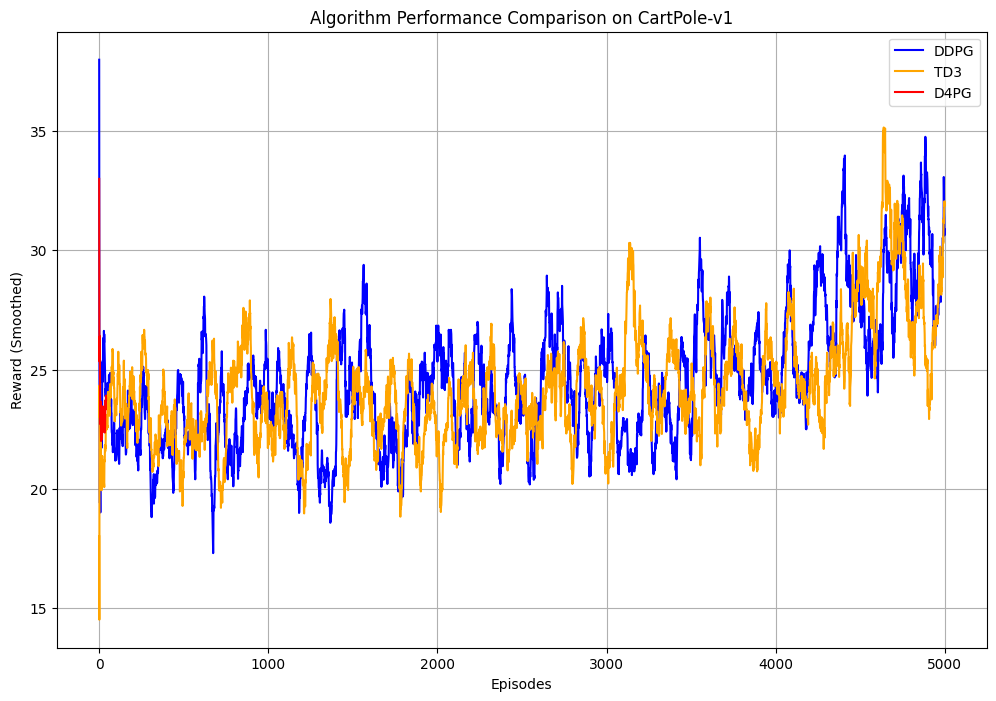

In [39]:
plt.figure(figsize=(12, 8))

# Moving average for smoothness
window = 50
ddpg_avg = [np.mean(training_rewards_ddpg[max(0, i - window):(i + 1)]) for i in range(len(training_rewards_ddpg))]
sac_avg = [np.mean(training_rewards_sac[max(0, i - window):(i + 1)]) for i in range(len(training_rewards_sac))]
td3_avg = [np.mean(training_rewards_td3[max(0, i - window):(i + 1)]) for i in range(len(training_rewards_td3))]
d4pg_avg = [np.mean(training_rewards_d4pg[max(0, i - window):(i + 1)]) for i in range(len(training_rewards_d4pg))]

plt.plot(ddpg_avg, label='DDPG', color='blue')
#plt.plot(sac_avg, label='SAC', color='green')
plt.plot(td3_avg, label='TD3', color='orange')
plt.plot(d4pg_avg, label='D4PG', color='red')

plt.title('Algorithm Performance Comparison on CartPole-v1')
plt.xlabel('Episodes')
plt.ylabel('Reward (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()
